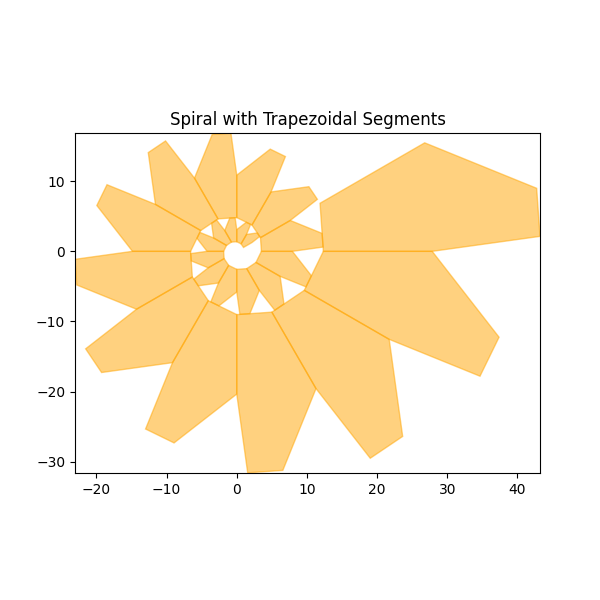

In [2]:
import numpy as np
from scipy.ndimage import  rotate
import matplotlib.pyplot as plt
import ezdxf

def spiral_arc_length(a,b,theta):
    return (a * np.sqrt(1 + b**2) / b) * (np.exp(b * theta) - 1)

def central_spiral_arc_length(a,b,theta):
    return (a * np.sqrt(1 + b**2) / b) * (np.exp(b * theta) - 1) * (1+np.exp(2*np.pi*b))/2

def spiral_radius(a,b,theta):
    return a*np.exp(b*theta)

def central_spiral_radius(a,b,theta):
    return (spiral_radius(a,b,theta) + spiral_radius(a,b,theta+2*np.pi))/2

def spiral_point(a,b,theta):
    r = spiral_radius(a,b,theta)
    return polar_to_cart(r, theta)

def central_spiral_point(a,b,theta):
    return (spiral_point(a,b,theta) + spiral_point(a,b,theta + np.pi*2))/2

def polar_to_cart(r,theta):
    return np.array([r * np.cos(theta), r * np.sin(theta)])

def vector_size(x1,y1,x2,y2):
    return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_spiral_trapezoid(a,b,theta,delta_theta):
    x1,y1 = central_spiral_point(a,b,theta)
    x2,y2 = central_spiral_point(a,b,theta + delta_theta)
    x3,y3 = spiral_point(a,b,theta + delta_theta)
    x4,y4 = spiral_point(a,b,theta)

    # r2 = central_spiral_radius(a, b, theta - delta_theta)
    # r3 = spiral_radius(a, b, theta - delta_theta)
    # taper_shift = r2 - r3
    # diff_x3, diff_y3 = polar_to_cart(taper_shift, theta - delta_theta)
    # x3, y3 = x2 - diff_x3, y2 - diff_y3
    
    # base_width = vector_size(x1,y1,x2,y2)
    # delta = base_width * r3 / r2
    # slope = (x2-x1) * delta/base_width, (y2-y1) * delta/base_width
    # x4, y4 = x3-slope[0], y3-slope[1]
    return np.array([[x2, y2], [x1, y1], [x4, y4], [x3, y3]])

def get_rotation_matrix(rad):
    return np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])

def rotate_vector(vector, rad):
    rotation_matrix = get_rotation_matrix(rad)
    return rotation_matrix @ vector

def reflect_point_across_line(P, A, B):
    """ Reflects point P across the line passing through A and B. """
    AB = B - A
    AB_unit = AB / np.linalg.norm(AB)  # Unit direction vector of line AB
    projection = A + np.dot(P - A, AB_unit) * AB_unit  # Projection of P onto line AB
    return 2 * projection - P  # Reflection formula

def get_hexagon_by_mirroring(trapezoid):
    p2, p1, p4, p3 = trapezoid  # Assume counterclockwise ordering
    
    p5 = reflect_point_across_line(p3, p1, p2)
    p6 = reflect_point_across_line(p4, p1, p2)

    return np.array([p3, p2, p5, p6, p1, p4])

def place(hexagon, p1, p2, dist):
    v = p2 - p1
    angle = np.arctan2(v[1], v[0])
    rot = get_rotation_matrix(-angle)
    hexagon -= p2
    hexagon = hexagon @ rot.T
    hexagon += np.array((dist,0))
    return hexagon, dist - np.linalg.norm(v)

def generate_hexagons(a=1, b=0.2, theta_max=4*np.pi, delta_theta=np.pi/6, flatten=True):
    last_point = 0
    hexagons = []
    dist = central_spiral_arc_length(a,b,theta_max)
    for theta in np.arange(theta_max,0,-delta_theta):
        trapezoid = get_spiral_trapezoid(a, b, theta, delta_theta)
        hexagon = get_hexagon_by_mirroring(trapezoid)
        if flatten:
            hexagon, dist = place(hexagon, hexagon[4], hexagon[1], dist)
        hexagons.append(hexagon)

    return hexagons
        

def plot_spiral_trapezoids(hexagons, a=1, b=0.2, theta_max=4*np.pi, delta_theta=np.pi/6):
    """
    Plots all trapezoidal segments along the spiral.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    for hexagon in hexagons:
        ax.add_patch(plt.Polygon(hexagon, closed=True, color='orange', alpha=0.5))

    point_list = np.concatenate(hexagons)
    minx, miny = np.min(point_list,axis=0)
    maxx, maxy = np.max(point_list,axis=0)
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect('equal')
    plt.title("Spiral with Trapezoidal Segments")
    plt.show()

def get_dxf(hexagons,dxf_filename='spiral.dxf'):
    doc = ezdxf.new()
    doc.units = ezdxf.units.MM
    msp = doc.modelspace()
    
    for hexagon in hexagons:
        msp.add_lwpolyline(hexagon, close=True)
    doc.saveas(dxf_filename)
    print(f"DXF file saved as {dxf_filename}")


%matplotlib widget
plot_spiral_trapezoids(generate_hexagons(flatten=False, delta_theta=np.pi/6))



None False
{'name': 'value', 'old': 0.5, 'new': 0.988934076082006, 'owner': FloatSlider(value=0.988934076082006, description='Max Height', max=17.98061956512738, min=0.899030978256369, step=0.01), 'type': 'change'} False
{'name': 'value', 'old': 0.01, 'new': 0.2131941196271254, 'owner': FloatSlider(value=0.2131941196271254, description='Length', max=200.0, min=0.01, step=0.01), 'type': 'change'} True
1.110399383005586 0.10471975511965977 0.8139446957231167


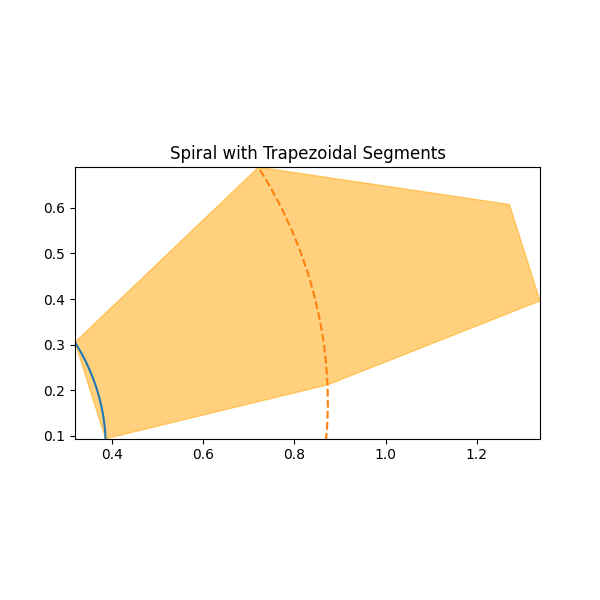

In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio 
# Reverse arc length to theta
def inverse_central_spiral_arc_length(a, b, arc_len):
    return (1 / b) * np.log(1 + (arc_len * 2 * b) / (a * np.sqrt(1 + b**2) * (1 + np.exp(2 * np.pi * b))))


def max_W_from_H(H_max, b, delta_theta):
    exp_2pi_b = np.exp(2 * np.pi * b)
    exp_bdtheta = np.exp(b * delta_theta)
    exp_2bdtheta = np.exp(2 * b * delta_theta)
    sin_dtheta = np.sin(delta_theta)
    cos_dtheta = np.cos(delta_theta)

    shape_term = 1 + exp_2bdtheta - 2 * exp_bdtheta * cos_dtheta

    W_max = (
        H_max * (1 + exp_2pi_b) * shape_term
        / (2 * (exp_2pi_b - 1) * sin_dtheta)
    )

    return W_max
def min_H_from_W(W_max, b, delta_theta):
    exp_2pi_b = np.exp(2 * np.pi * b)
    exp_bdtheta = np.exp(b * delta_theta)
    exp_2bdtheta = np.exp(2 * b * delta_theta)
    sin_dtheta = np.sin(delta_theta)
    cos_dtheta = np.cos(delta_theta)

    shape_term = 1 + exp_2bdtheta - 2 * exp_bdtheta * cos_dtheta

    H_min = (
        2 * W_max * (exp_2pi_b - 1) * sin_dtheta
        / ((1 + exp_2pi_b) * shape_term)
    )

    return H_min


# Compute delta_theta from arc length difference
def max_width_to_delta_theta(a, b, arc_len, max_width):
    theta1 = inverse_central_spiral_arc_length(a, b, arc_len)
    theta2 = inverse_central_spiral_arc_length(a, b, arc_len - max_width)
    return theta1 - theta2

def solve_theta_and_a_from_Hmax_Wmax(H_max, W_max, b, delta_theta):
    exp_2pi_b = np.exp(2 * np.pi * b)
    exp_bdtheta = np.exp(b * delta_theta)
    exp_2bdtheta = np.exp(2 * b * delta_theta)
    sin_dtheta = np.sin(delta_theta)
    cos_dtheta = np.cos(delta_theta)

    shape_term = 1 + exp_2bdtheta - 2 * exp_bdtheta * cos_dtheta

    log_arg = (
        H_max * (1 + exp_2pi_b) /
        (2 * W_max * (exp_2pi_b - 1) * sin_dtheta)
    ) * shape_term

    theta_max = (1 / (2 * b)) * np.log(log_arg)

    # Compute 'a' using base length formula
    exp_2b_theta = np.exp(2 * b * theta_max)
    exp_2b_theta_dtheta = np.exp(2 * b * (theta_max + delta_theta))
    exp_2b_theta_plus_bdtheta = np.exp(2 * b * theta_max + b * delta_theta)

    base_length_sqrt = np.sqrt(
        exp_2b_theta + exp_2b_theta_dtheta -
        2 * exp_2b_theta_plus_bdtheta * cos_dtheta
    )

    a = 2 * W_max / ((1 + exp_2pi_b) * base_length_sqrt)

    return theta_max, a
    
def solve_a_and_theta_from_L_and_Hmax(L, H_max, b, delta_theta):
    exp_2pi_b = np.exp(2 * np.pi * b)
    exp_bdtheta = np.exp(b * delta_theta)
    exp_2bdtheta = np.exp(2 * b * delta_theta)
    sin_dtheta = np.sin(delta_theta)
    cos_dtheta = np.cos(delta_theta)

    shape_term = np.sqrt(1 + exp_2bdtheta - 2 * exp_bdtheta * cos_dtheta)

    # Solve for a
    numerator = 2 * b * L
    denominator = (
        (H_max * shape_term) /
        (exp_bdtheta * (exp_2pi_b - 1) * sin_dtheta)
        - 1
    ) * np.sqrt(1 + b**2) * (1 + exp_2pi_b)

    a = numerator / denominator

    # Then compute theta_max from arc length expression
    theta_max = (1 / b) * np.log(
        1 + (2 * b * L) / (a * np.sqrt(1 + b**2) * (1 + exp_2pi_b))
    )

    return theta_max, a

def hexagon_height(a, b, theta, delta_theta):
    exp_b_theta = np.exp(b * theta)
    exp_b_theta_dtheta = np.exp(b * (theta + delta_theta))
    exp_2b_theta = exp_b_theta ** 2
    exp_2b_theta_dtheta = exp_b_theta_dtheta ** 2
    exp_2b_theta_plus_bdtheta = np.exp(2 * b * theta + b * delta_theta)
    exp_2pi_b = np.exp(2 * np.pi * b)

    numerator = a * exp_2b_theta_plus_bdtheta * (exp_2pi_b - 1) * np.sin(delta_theta)
    denominator = np.sqrt(
        exp_2b_theta + exp_2b_theta_dtheta - 2 * exp_2b_theta_plus_bdtheta * np.cos(delta_theta)
    )

    return numerator / denominator

def base_length(a, b, theta, delta_theta):
    exp_b_theta = np.exp(b * theta)
    exp_b_theta_dtheta = np.exp(b * (theta + delta_theta))
    exp_2b_theta = exp_b_theta ** 2
    exp_2b_theta_dtheta = exp_b_theta_dtheta ** 2
    exp_2b_theta_plus_bdtheta = np.exp(2 * b * theta + b * delta_theta)
    exp_2pi_b = np.exp(2 * np.pi * b)

    length = 0.5 * a * (1 + exp_2pi_b) * np.sqrt(
        exp_2b_theta + exp_2b_theta_dtheta - 2 * exp_2b_theta_plus_bdtheta * np.cos(delta_theta)
    )

    return length


# UI widgets
arc_length_slider = widgets.FloatSlider(value=0.01, min=0.01, max=200.0, step=0.01, description='Length')
max_width_slider = widgets.FloatSlider(value=0.5, min=0.01, max=20.0, step=0.01, description='Max Width')
max_height_slider = widgets.FloatSlider(value=0.5, min=0.01, max=20.0, step=0.01, description='Max Height')
flatten_checkbox = widgets.Checkbox(value=False, description='Flatten')
export_button = widgets.Button(description="Export DXF")

output = widgets.Output()
fig, ax = plt.subplots(figsize=(6, 6))

# HACK
lock = False
# CONST
b = 0.2
delta_theta = np.pi/6

# Callback function
def update_plot(change=None):
    global lock
    print(change, lock)
    if lock:
        return
    arc_len = arc_length_slider.value
    max_width = max_width_slider.value
    max_height = max_height_slider.value
    flatten = flatten_checkbox.value

    min_H = min_H_from_W(max_width, b, delta_theta)
    if max_height < min_H:
        with max_height_slider.hold_trait_notifications():
            max_height_slider.value = min_H * 1.1
            max_height_slider.min = min_H
            max_height_slider.max = min_H*20
            
        return
    else:
        max_height_slider.min = min_H

    lock = True
    theta_max,a = solve_theta_and_a_from_Hmax_Wmax(max_height, max_width, b, delta_theta)
    L = central_spiral_arc_length(a,b,theta_max)
    if change is not None and change.owner == arc_length_slider:
        ratio = arc_len/L
        max_height = max_height * ratio
        if max_height > max_height_slider.min:
            max_height_slider.value = max_height
            theta_max,a = solve_theta_and_a_from_Hmax_Wmax(max_height, max_width, b, delta_theta)
            L = central_spiral_arc_length(a,b,theta_max)
        else:
            arc_length_slider.value = L
    else:
        arc_length_slider.value = L
    lock = False
    if theta_max < 0:
        return
    if a< 0:
        return

    print(np.exp(delta_theta * b), b*delta_theta, np.log(1+ 1/2 * (np.exp(2*np.pi*b) - 1)))

    hexagons = generate_hexagons(a, b, theta_max, delta_theta, flatten)[::-1]

    ax.clear()
    for hexagon in hexagons:
        ax.add_patch(plt.Polygon(hexagon, closed=True, color='orange', alpha=0.5))
    if not len(hexagons):
        return
    point_list = np.concatenate(hexagons)
    minx, miny = np.min(point_list, axis=0)
    maxx, maxy = np.max(point_list, axis=0)
    x,y = spiral_point(a,b,np.arange(theta_max+ np.pi*2,0, step=-delta_theta/10))
    ax.plot(x,y)
    x,y = central_spiral_point(a,b,np.arange(theta_max+ np.pi*2,0, step=-delta_theta/10))
    ax.plot(x,y, ls="--")
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect('equal')
    ax.set_title("Spiral with Trapezoidal Segments")
    fig.canvas.draw()
    

def export_dxf_clicked(evt):
    flatten = flatten_checkbox.value
    max_width = max_width_slider.value
    max_height = max_height_slider.value
    
    theta_max,a = solve_theta_and_a_from_Hmax_Wmax(max_height, max_width, b, delta_theta)
    

    hexagons = generate_hexagons(a, b, theta_max, delta_theta, flatten)
    get_dxf(hexagons)

# Attach handlers
arc_length_slider.observe(update_plot, names='value')
max_width_slider.observe(update_plot, names='value')
max_height_slider.observe(update_plot,names='value')
flatten_checkbox.observe(update_plot, names='value')
export_button.on_click(export_dxf_clicked)

# Layout
ui = widgets.VBox([
    widgets.HBox([arc_length_slider, max_width_slider, max_height_slider]),
    widgets.HBox([flatten_checkbox, export_button]),
    output
])

display(ui)
update_plot()